# Recommender system on Movies 

In [1]:
# import relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings; warnings.simplefilter('ignore')
import ast

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate


#animation and dynamic visualization 
import plotly
import plotly.graph_objects as go
import plotly.express as px              #the ploty function enable us to realize some interacting function in the visualization 
from plotly.offline import iplot,init_notebook_mode
import cufflinks as cf                   #the visualizzation tool 
from scipy import stats                  #the package can be used to apply some basic regression method into application

%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
#plotly.offline.iplot()
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)

## Data Preprocessing Part

In [2]:
data = pd.read_csv("movies_metadata.csv")
data['genres'] = data['genres'].fillna('[]').apply(literal_eval)\
    .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# since the english movies are the majority of the dataset
# we choose to only recommend the english movies 
data = data[data ['original_language'] == 'en']

data = data.drop(['belongs_to_collection','adult','homepage','original_language',\
                  'original_title','poster_path','status','spoken_languages',\
                  'video','budget','revenue','runtime'],axis = 1)

data['production_countries'] = data['production_countries'].fillna('[]')\
    .apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_countries'] = data['production_countries'].apply(lambda x: x[0] if x!= [] else np.nan)

data['production_companies'] = data['production_companies'].fillna('[]')\
    .apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_companies'] = data['production_companies'].apply(lambda x: x[0] if x!= [] else np.nan)

data['release_date'] = data['release_date'].fillna('0').apply(lambda x: x.split('-')[0] )

data['id'] = data['id'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32269 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                32269 non-null  object 
 1   id                    32269 non-null  int32  
 2   imdb_id               32256 non-null  object 
 3   overview              32200 non-null  object 
 4   popularity            32267 non-null  object 
 5   production_companies  23663 non-null  object 
 6   production_countries  27047 non-null  object 
 7   release_date          32269 non-null  object 
 8   tagline               17933 non-null  object 
 9   title                 32267 non-null  object 
 10  vote_average          32267 non-null  float64
 11  vote_count            32267 non-null  float64
dtypes: float64(2), int32(1), object(9)
memory usage: 3.1+ MB


In [3]:
# process the data from other sources and extract the director and actor information from credits
# keywords information from keywords dataset 
credits = pd.read_csv('credits.csv')
credits['id'] = credits['id'].astype(int)

def get_director(list):
    for i in list:
        if i['job'] == 'Director': return i['name']
    return np.nan

credits["director"] = credits['crew'].fillna('[]').apply(ast.literal_eval).\
                    apply(get_director)

credits["actors"] = credits['cast'].fillna('[]').apply(ast.literal_eval).\
                    apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []).\
                    apply(lambda x: x[:3] if len(x) >=3 else x)

credits = credits.drop(['cast','crew'],axis = 1)

keywords = pd.read_csv('keywords.csv')
keywords['id'] = keywords['id'].astype(int)

keywords['keylist'] = keywords['keywords'].fillna('[]').apply(ast.literal_eval).\
                    apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

keywords = keywords.drop(['keywords'],axis = 1) 

In [4]:
# merge the metadata together with the outside source information 
data = data.merge(credits, on='id')
data = data.merge(keywords, on='id')
data = data.reset_index(drop = True)
data.head(2).transpose()

,0,1
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]"
id,862,8844
imdb_id,tt0114709,tt0113497
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...
popularity,21.946943,17.015539
production_companies,Pixar Animation Studios,TriStar Pictures
production_countries,United States of America,United States of America
release_date,1995,1995
tagline,NaN,Roll the dice and unleash the excitement!
title,Toy Story,Jumanji


In [5]:
# utilize the user-rating dataset to implement the collarbrative filtering 
from surprise import Reader
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Data distribution and visualization part

In [6]:
s = data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'classfy'
genres = data.join(s)
# list all the genres of the movies in the dataset
genreslist = genres['classfy'].unique()
newlist = np.delete(genreslist,15)
print(newlist)

['Animation' 'Comedy' 'Family' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'History' 'Science Fiction'
 'Mystery' 'War' 'Music' 'Documentary' 'Foreign' 'Western' 'TV Movie']


In [7]:
genres = genres[genres['release_date'] != '0']
gen = genres.groupby(by = ["classfy"]).agg({'id':'count'})
year = data[data['release_date'] != '0'].groupby(by = ['release_date']).agg({'id':"count"})
combine = genres.groupby(by = ["classfy",'release_date']).agg({'id':'count'})

year = year.reset_index()
year['release_date'] = year['release_date'].astype('int')

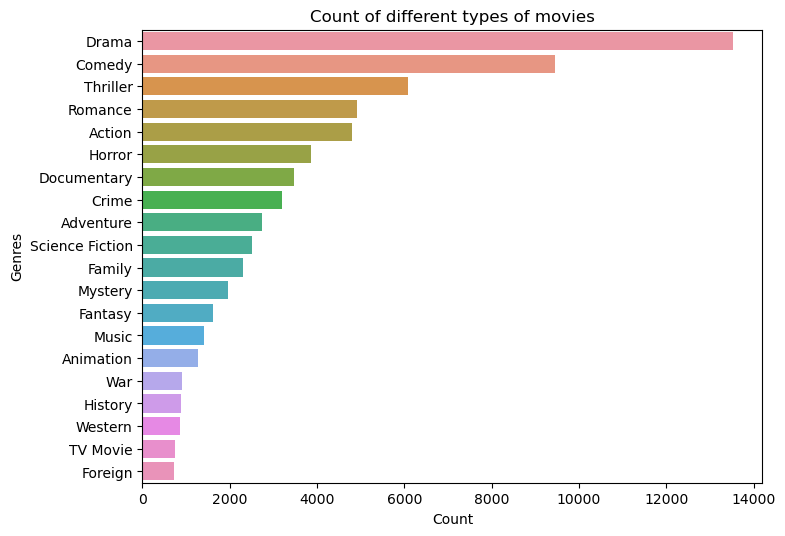

In [8]:
plt.figure(figsize = (8,6),dpi = 100)
sns.barplot(data = gen.reset_index().sort_values(by = 'id',ascending= False), x = "id", y = 'classfy',orient = 'h')
plt.title("Count of different types of movies")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

In [9]:
import plotly.express as px
year.columns = ['release_year','Count of movies']

fig = px.line(year[year['release_year']<= 2015], x='release_year', y='Count of movies', title='The trend of movie quantities by year')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [10]:
title = 'Different top genres trend'
labels = ['Drama', 'Comedy','Thriller','Romance','Action']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)','rgb(115,115,115)']
mode_size = [8, 8, 12, 8]
line_size = [2, 2, 4, 2]
x_data = np.vstack((np.arange(2005, 2017),)*4)
y_data = np.array([
    combine.loc['Drama'].iloc[-15:-3].values.flatten(),
    combine.loc['Comedy'].iloc[-15:-3].values.flatten(),
    combine.loc['Thriller'].iloc[-15:-3].values.flatten(),
    combine.loc['Romance'].iloc[-15:-3].values.flatten()])
fig = go.Figure()
for i in range(0, 4):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],line=dict(color=colors[i], width=line_size[i]),connectgaps=True,))
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],y=[y_data[i][0], y_data[i][-1]],
        mode='markers',marker=dict(color=colors[i], size=mode_size[i])))
fig.update_layout(
    xaxis=dict(showline=True,showgrid=False,showticklabels=True,linecolor='rgb(204, 204, 204)',linewidth=2,
        ticks='outside',tickfont=dict(family='Arial',size=12,color='rgb(82, 82, 82)',),),
    yaxis=dict(showgrid=False,zeroline=False,showline=False,showticklabels=False,),
    autosize=False,margin=dict(autoexpand=False,l=100,r=20,t=110,),showlegend=False,plot_bgcolor='white')
annotations = []
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}'.format(y_trace[0]),
                                  font=dict(family='Arial',size=16),showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
                                  xanchor='left', yanchor='middle',
                                  text='{}'.format(y_trace[11]),
                                  font=dict(family='Arial',size=16),showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Different types of movies\' trend',
                              font=dict(family='Arial',size=30,color='rgb(37,37,37)'),showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: Moives DataSet from CC0: Public Domain',
                              font=dict(family='Arial',size=12,color='rgb(150,150,150)'),showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

## User-Rating based collaberative filtering part 

In [11]:
from surprise import SVD
data2 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())
svd = SVD()
svdmodel = surprise.model_selection.cross_validate(svd, data2, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9054  0.9074  0.9010  0.9046  0.0027  
MAE (testset)     0.6994  0.6983  0.6938  0.6972  0.0024  
Fit time          2.62    2.65    2.70    2.65    0.03    
Test time         0.18    0.27    0.18    0.21    0.04    


In [12]:
from surprise import BaselineOnly
algo = BaselineOnly()
basemodel = surprise.model_selection.cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=3,verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8975  0.8996  0.8949  0.8973  0.0019  
MAE (testset)     0.6945  0.6955  0.6918  0.6939  0.0015  
Fit time          0.11    0.11    0.12    0.12    0.00    
Test time         0.12    0.22    0.11    0.15    0.05    


In [13]:
from surprise import KNNWithMeans
algo = KNNWithMeans()
meanmodel = surprise.model_selection.cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=3,verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9293  0.9244  0.9270  0.9269  0.0020  
MAE (testset)     0.7115  0.7075  0.7110  0.7100  0.0018  
Fit time          0.12    0.12    0.13    0.13    0.00    
Test time         1.85    1.79    1.84    1.83    0.02    


In [14]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
table_data = [['Models','RMSE', 'MAE', 'Fit Time','Test Time'],
              ['svd',svdmodel['test_rmse'].mean().round(3),svdmodel['test_mae'].mean().round(3),round(svdmodel['fit_time'][1],3),round(svdmodel['test_time'][1],3)],
              ['base',basemodel['test_rmse'].mean().round(3),basemodel['test_mae'].mean().round(3),round(basemodel['fit_time'][1],3),round(basemodel['test_time'][1],3)],
              ['mean',meanmodel['test_rmse'].mean().round(3),meanmodel['test_mae'].mean().round(3),round(meanmodel['fit_time'][1],3),round(meanmodel['test_time'][1],3)]]
fig = ff.create_table(table_data, height_constant=20)
teams = ['SVD','Base','Mean']

# create four different bars 
nm = [svdmodel['test_rmse'].mean(),svdmodel['test_rmse'].mean(),svdmodel['test_rmse'].mean()]
fm = [svdmodel['test_mae'].mean(),svdmodel['test_mae'].mean(),svdmodel['test_mae'].mean()]
ns = [svdmodel['fit_time'][1],svdmodel['fit_time'][1],svdmodel['fit_time'][1]]
fs = [svdmodel['test_time'][1],svdmodel['test_time'][1],svdmodel['test_time'][1]]

# Make traces for graph
trace1 = go.Bar(x=teams, y=nm, xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='RMSE')
trace2 = go.Bar(x=teams, y=fm, xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='MAE')
trace3 = go.Bar(x=teams, y=ns, xaxis='x2', yaxis='y2',
                marker=dict(color='red'),
                name='Fit Time')
trace4 = go.Bar(x=teams, y=fs, xaxis='x2', yaxis='y2',
                marker=dict(color='green'),
                name='Test Time')
# Add trace data to figure
fig.add_traces([trace1, trace2,trace3,trace4])
# initialize xaxis2 and yaxis2
fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.yaxis.update({'domain': [0, .55]})
fig.layout.yaxis2.update({'domain': [.6, 1]})

# The graph's yaxis2 MUST BE anchored to the graph's xaxis2 and vice versa
fig.layout.yaxis2.update({'anchor': 'x2'})
fig.layout.xaxis2.update({'anchor': 'y2'})
fig.layout.yaxis2.update({'title': 'Comparisons'})

# Update the margins to add a title and see graph x-labels.
fig.layout.margin.update({'t':50, 'l':50})
fig.layout.update({'title': 'The Comparison of different models'})

# Update the height because adding a graph vertically will interact with the plot height calculated for the table
fig.layout.update({'height':400})
fig.show()

In [15]:
round(svdmodel['fit_time'][1],3)


2.649

## The content based recommender

Description based recommender 

In [16]:
data['text'] = data['tagline'].fillna('') + data['overview'].fillna('')
data['text'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    Roll the dice and unleash the excitement!When ...
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: text, dtype: object

In [17]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data['text'])

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indice = pd.Series(data.index,index = data['title'])
def recommend_movie(name):
    idx = indice[name]
    similarity = list(enumerate(cosine_sim[idx]))
    similarity = sorted(similarity,key = lambda x:x[1], reverse = True)
    idxlist = [i[0] for i in similarity[1:10]]
    return data['title'].iloc[idxlist]

In [18]:
recommend_movie('Toy Story')

2697                                      Toy Story 2
12403                                     Toy Story 3
18994                                       Small Fry
18475                     Andy Hardy's Blonde Trouble
7263                                        The Champ
31769                Andy Kaufman Plays Carnegie Hall
8645                           The 40 Year Old Virgin
2754                                  Man on the Moon
28525    Superstar: The Life and Times of Andy Warhol
Name: title, dtype: object

Keywords based recommender 

In [19]:
s = data.apply(lambda x: pd.Series(x['keylist']),axis=1).stack().reset_index(level=1, drop=True)
dictcount = s.value_counts()
dictcount = dictcount[dictcount > 5]
data['director'] = data['director'].apply(lambda x: [x])

In [20]:
stemmer = SnowballStemmer('english')
def filter_keywords(x):
    words = []
    for i in x:
        if i in dictcount: words.append(i)
    return words
data['keylist'] = data['keylist'].apply(filter_keywords)
data['keylist'] = data['keylist'].apply(lambda x: [stemmer.stem(i) for i in x])
data['keylist'] = data['keylist'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
data['keylist']

0        [jealousi, toy, boy, friendship, friend, rival...
1        [boardgam, disappear, basedonchildren'sbook, n...
2                   [fish, bestfriend, duringcreditssting]
3        [basedonnovel, interracialrelationship, single...
4        [babi, midlifecrisi, confid, age, daughter, mo...
                               ...                        
32932                                                   []
32933                                                   []
32934                                                   []
32935                                                   []
32936                                                   []
Name: keylist, Length: 32937, dtype: object

In [21]:
data['feature'] = data['keylist']  + data['director'] \
                + data['genres'] + data['actors']
data['feature'] = data['feature'].apply(lambda x: ' '.join(map(str,x)))
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(data['feature'])

In [22]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [23]:
def recommend_movie2(name):
    idx = indice[name]
    similarity = sorted(list(enumerate(cosine_sim2[idx])),key = lambda x:x[1], reverse = True)
    idxlist = [i[0] for i in similarity[1:10]]
    return data['title'].iloc[idxlist]

recommend_movie2('Toy Story')

2697                    Toy Story 2
17099          Toy Story of Terror!
19921    Toy Story That Time Forgot
19919               Partysaurus Rex
12403                   Toy Story 3
8914                       Luxo Jr.
14996                       Tin Toy
15026                   Red's Dream
2985              Creature Comforts
Name: title, dtype: object

Build Movie rating model 
Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$  
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

In [24]:
vote_counts = data[data['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = data[data['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

In [25]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
data['weighted'] = data.apply(weighted_rating,axis = 1)

In [51]:
# print the top 10 movies 
data.sort_values('weighted',ascending= False).loc[:,['title','weighted']].head(10)

,title,weighted
280,The Shawshank Redemption,8.262609
734,The Godfather,8.179341
10314,The Dark Knight,8.144355
2566,Fight Club,8.105232
265,Pulp Fiction,8.084122
315,Forrest Gump,7.978436
12503,Inception,7.972039
17744,Interstellar,7.940766
1023,The Empire Strikes Back,7.906598
482,Schindler's List,7.903698
